# ISOT Fake News Dataset - Exploratory Data Analysis

This notebook focuses on exploratory data analysis of the ISOT Fake News Dataset, which contains real news from Reuters.com and fake news from various unreliable sources. My goal is to understand the data characteristics and identify potential biases that might impact model training.

## 1. Setup and Data Loading

First, I'll import the necessary libraries and load our datasets.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import string
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('ggplot')
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 200)

[nltk_data] Downloading package stopwords to /Users/amid/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/amid/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Now I'll load both datasets and take a quick look at them:

In [2]:
# Load the datasets
true_news = pd.read_csv('../data/ISOT/True.csv')
fake_news = pd.read_csv('../data/ISOT/Fake.csv')

# Display basic info about the datasets
print("True News Dataset Shape:", true_news.shape)
print("Fake News Dataset Shape:", fake_news.shape)

True News Dataset Shape: (21417, 4)
Fake News Dataset Shape: (23481, 4)


## 2. Initial Data Exploration

I'll examine both datasets to understand their structure and content.

In [3]:
# Display the first few rows of each dataset
print("True News Dataset Sample:")
true_news.head(3)

True News Dataset Sample:


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip their fiscal script","WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fis...",politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits on Monday: Pentagon,"WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after Pres...",politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Mueller do his job',"WASHINGTON (Reuters) - The special counsel investigation of links between Russia and President Trump’s 2016 election campaign should continue without interference in 2018, despite calls from some ...",politicsNews,"December 31, 2017"


In [4]:
print("Fake News Dataset Sample:")
fake_news.head(3)

Fake News Dataset Sample:


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing,"Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. The former...",News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian Collusion Investigation,"House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia inve...",News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’,"On Friday, it was revealed that former Milwaukee Sheriff David Clarke, who was being considered for Homeland Security Secretary in Donald Trump s administration, has an email scandal of his own.In...",News,"December 30, 2017"


Let's check the columns in each dataset to ensure they have similar structures:

In [5]:
# Check columns in each dataset
print("True News Columns:", true_news.columns.tolist())
print("Fake News Columns:", fake_news.columns.tolist())

# Check for missing values
print("\nMissing Values in True News:")
print(true_news.isnull().sum())
print("\nMissing Values in Fake News:")
print(fake_news.isnull().sum())

True News Columns: ['title', 'text', 'subject', 'date']
Fake News Columns: ['title', 'text', 'subject', 'date']

Missing Values in True News:
title      0
text       0
subject    0
date       0
dtype: int64

Missing Values in Fake News:
title      0
text       0
subject    0
date       0
dtype: int64


## 3. Identifying the "(Reuters)" Pattern

I suspect that true news articles contain a specific pattern "(Reuters)" that might lead to model overfitting. Let's investigate this:

In [6]:
# Check for "(Reuters)" in the text of true news articles
reuters_count = true_news['text'].str.contains('\(Reuters\)').sum()
print(f"Number of true news articles containing '(Reuters)': {reuters_count}")
print(f"Percentage: {reuters_count / len(true_news) * 100:.2f}%")

# Let's see some examples
print("\nSample of true news beginning:")
for i in range(3):
    print(f"\nArticle {i+1} beginning:")
    print(true_news['text'].iloc[i][:200])

Number of true news articles containing '(Reuters)': 21247
Percentage: 99.21%

Sample of true news beginning:

Article 1 beginning:
WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal 

Article 2 beginning:
WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as ordered by federal courts, the Pentagon said on Friday, after Presiden

Article 3 beginning:
WASHINGTON (Reuters) - The special counsel investigation of links between Russia and President Trump’s 2016 election campaign should continue without interference in 2018, despite calls from some Trum


Let's also check if fake news ever contains this pattern:

In [7]:
# Check if fake news articles contain "(Reuters)"
fake_reuters_count = fake_news['text'].str.contains('\(Reuters\)').sum()
print(f"Number of fake news articles containing '(Reuters)': {fake_reuters_count}")
print(f"Percentage: {fake_reuters_count / len(fake_news) * 100:.2f}%")

Number of fake news articles containing '(Reuters)': 9
Percentage: 0.04%


I'm checking for the "(Reuters)" pattern because if all true news articles contain this pattern and fake news doesn't, our model might learn to classify articles based on this pattern alone rather than learning the actual substantive differences. This would lead to poor generalization when applied to new data without this specific marker.

## 4. Exploring Other Potential Patterns or Biases

Now I'll look for other patterns or markers that might create similar biases:

In [8]:
# Function to check for common prefixes/suffixes in the text
def check_common_patterns(series, n=20, prefix_length=30):
    """
    Check for common patterns at the beginning and end of texts
    
    Args:
        series: Pandas series containing text data
        n: Number of most common patterns to return
        prefix_length: Length of prefix/suffix to check
    
    Returns:
        Dictionary with common prefixes and suffixes
    """
    prefixes = Counter([text[:prefix_length].strip() for text in series if isinstance(text, str) and len(text) > prefix_length])
    suffixes = Counter([text[-prefix_length:].strip() for text in series if isinstance(text, str) and len(text) > prefix_length])
    
    return {
        'prefixes': prefixes.most_common(n),
        'suffixes': suffixes.most_common(n)
    }

# Check patterns in true news
print("Common patterns in True News:")
true_patterns = check_common_patterns(true_news['text'])
for prefix, count in true_patterns['prefixes'][:5]:
    print(f"Prefix: '{prefix}' - Count: {count}")

# Check patterns in fake news
print("\nCommon patterns in Fake News:")
fake_patterns = check_common_patterns(fake_news['text'])
for prefix, count in fake_patterns['prefixes'][:5]:
    print(f"Prefix: '{prefix}' - Count: {count}")

Common patterns in True News:
Prefix: 'WASHINGTON (Reuters) - Preside' - Count: 744
Prefix: 'WASHINGTON (Reuters) - U.S. Pr' - Count: 690
Prefix: 'WASHINGTON (Reuters) - The U.S' - Count: 577
Prefix: 'WASHINGTON (Reuters) - Republi' - Count: 323
Prefix: 'WASHINGTON (Reuters) - U.S. Se' - Count: 296

Common patterns in Fake News:
Prefix: 'Tune in to the Alternate Curre' - Count: 203
Prefix: 'https://www.youtube.com/watch?' - Count: 68
Prefix: 'Shawn Helton 21st Century Wire' - Count: 36
Prefix: 'Patrick Henningsen 21st Centur' - Count: 32
Prefix: 'Amateur president Donald Trump' - Count: 17


Let's analyze location patterns in true news articles:

In [9]:
# Analyze location patterns in true news
def extract_locations(texts):
    """Extract location datelines from the beginning of articles"""
    locations = []
    for text in texts:
        if isinstance(text, str):
            # Look for capitalized words at the beginning followed by Reuters
            match = re.match(r'^([A-Z]+(?:\s[A-Z]+)*)\s*\(Reuters\)', text)
            if match:
                locations.append(match.group(1))
    return Counter(locations)

true_locations = extract_locations(true_news['text'])
print("Most common locations in True News:")
print(true_locations.most_common(10))

# Check if fake news has similar location patterns
fake_locations_pattern = fake_news['text'].str.match(r'^([A-Z]+(?:\s[A-Z]+)*)\s*\(').sum()
print(f"Fake news articles with apparent location datelines: {fake_locations_pattern}")
print(f"Percentage: {fake_locations_pattern / len(fake_news) * 100:.2f}%")

Most common locations in True News:
[('WASHINGTON', 6392), ('LONDON', 705), ('NEW YORK', 696), ('MOSCOW', 623), ('BERLIN', 500), ('BEIJING', 433), ('BRUSSELS', 346), ('BEIRUT', 346), ('PARIS', 301), ('ANKARA', 247)]
Fake news articles with apparent location datelines: 1
Percentage: 0.00%


Let's also look at common sources mentioned in both datasets:

In [10]:
# Function to extract potential source patterns
def extract_sources(text):
    """Extract potential source identifiers from text"""
    # Look for patterns like "(Reuters)", "(CNN)", etc.
    sources = re.findall(r'\([A-Za-z]+\)', text)
    return sources

# Apply to both datasets
true_sources = []
for text in true_news['text']:
    if isinstance(text, str):
        true_sources.extend(extract_sources(text))

fake_sources = []
for text in fake_news['text']:
    if isinstance(text, str):
        fake_sources.extend(extract_sources(text))

# Count and display the most common sources
print("Most common sources in True News:")
print(Counter(true_sources).most_common(10))

print("\nMost common sources in Fake News:")
print(Counter(fake_sources).most_common(10))

Most common sources in True News:
[('(Reuters)', 21249), ('(SPD)', 150), ('(FDP)', 144), ('(AfD)', 140), ('(CDU)', 103), ('(SDF)', 95), ('(Trump)', 88), ('(KRG)', 88), ('(NAFTA)', 85), ('(PKK)', 83)]

Most common sources in Fake News:
[('(s)', 409), ('(ACR)', 217), ('(id)', 174), ('(a)', 130), ('(R)', 109), ('(US)', 79), ('(D)', 74), ('(b)', 73), ('(DHS)', 64), ('(c)', 55)]


## 5. Text Length Analysis

I'll analyze the text length distribution for both real and fake news to identify any significant differences:

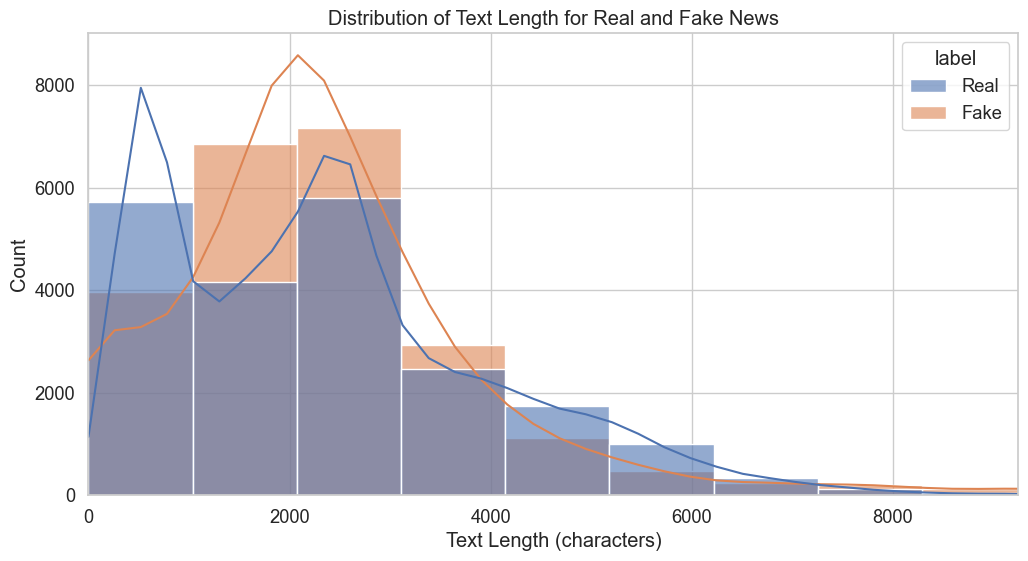

Text Length Statistics:
         count         mean          std  min     25%     50%     75%      max
label                                                                         
Fake   23481.0  2547.396235  2532.884399  1.0  1433.0  2166.0  3032.0  51794.0
Real   21417.0  2383.278517  1684.835730  1.0   914.0  2222.0  3237.0  29781.0


In [11]:
# Add text length as a feature
true_news['text_length'] = true_news['text'].apply(lambda x: len(str(x)))
fake_news['text_length'] = fake_news['text'].apply(lambda x: len(str(x)))

# Create a combined dataset for visualization
true_news['label'] = 'Real'
fake_news['label'] = 'Fake'
combined_df = pd.concat([true_news[['text_length', 'label']], fake_news[['text_length', 'label']]], axis=0)

# Plot the distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=combined_df, x='text_length', hue='label', bins=50, kde=True, alpha=0.6)
plt.title('Distribution of Text Length for Real and Fake News')
plt.xlabel('Text Length (characters)')
plt.ylabel('Count')
plt.xlim(0, combined_df['text_length'].quantile(0.99))  # Limit to 99th percentile for better visualization
plt.savefig('text_length_distribution.png')
plt.show()

# Print summary statistics
print("Text Length Statistics:")
print(combined_df.groupby('label')['text_length'].describe())

Analyzing text length is important because significant differences between real and fake news could become a feature that the model relies on too heavily. For instance, if fake news articles are consistently shorter, the model might classify short articles as fake regardless of content.

## 6. Basic Content Cleaning

Now I'll create a basic cleaning function to remove the "(Reuters)" pattern and any other identified markers that might bias our model:

In [12]:
# Function to clean text
def clean_text(text, patterns_to_remove=None):
    """
    Clean text by removing specified patterns
    
    Args:
        text: Text to clean
        patterns_to_remove: List of regex patterns to remove
    
    Returns:
        Cleaned text
    """
    if not isinstance(text, str):
        return ""
    
    cleaned_text = text
    
    if patterns_to_remove:
        for pattern in patterns_to_remove:
            cleaned_text = re.sub(pattern, '', cleaned_text)
    
    # Remove extra whitespace
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    
    return cleaned_text

# Patterns to remove from true news
true_patterns_to_remove = [
    r'\(Reuters\)',  # Remove (Reuters)
    # Add other patterns identified in the exploration
]

# Patterns to remove from fake news
fake_patterns_to_remove = [
    # Add patterns identified in the exploration
]

# Apply cleaning
true_news['cleaned_text'] = true_news['text'].apply(lambda x: clean_text(x, true_patterns_to_remove))
fake_news['cleaned_text'] = fake_news['text'].apply(lambda x: clean_text(x, fake_patterns_to_remove))

# Verify cleaning worked
print("Sample of cleaned true news:")
for i in range(3):
    print(f"\nOriginal text beginning: {true_news['text'].iloc[i][:100]}")
    print(f"Cleaned text beginning: {true_news['cleaned_text'].iloc[i][:100]}")

Sample of cleaned true news:

Original text beginning: WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted
Cleaned text beginning: WASHINGTON - The head of a conservative Republican faction in the U.S. Congress, who voted this mont

Original text beginning: WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. m
Cleaned text beginning: WASHINGTON - Transgender people will be allowed for the first time to enlist in the U.S. military st

Original text beginning: WASHINGTON (Reuters) - The special counsel investigation of links between Russia and President Trump
Cleaned text beginning: WASHINGTON - The special counsel investigation of links between Russia and President Trump’s 2016 el


I'm removing these patterns because they could create artificial signals that the model might latch onto during training. By removing them, I'm forcing the model to learn the actual stylistic and content differences between real and fake news rather than relying on specific markers.

## 7. Content Analysis

Let's analyze the actual content differences between real and fake news using word frequencies:

In [13]:
# Function to get most common words
def get_common_words(texts, n=20, min_length=3):
    """
    Get most common words in a list of texts
    
    Args:
        texts: List of text strings
        n: Number of most common words to return
        min_length: Minimum word length to consider
    
    Returns:
        Counter object with most common words
    """
    stop_words = set(stopwords.words('english'))
    words = []
    
    for text in texts:
        if isinstance(text, str):
            # Tokenize, convert to lowercase, remove punctuation and stopwords
            words_in_text = [word.lower().strip(string.punctuation) for word in nltk.word_tokenize(text)]
            words_in_text = [word for word in words_in_text if word not in stop_words and len(word) >= min_length and word.isalpha()]
            words.extend(words_in_text)
    
    return Counter(words).most_common(n)

# Get common words for both datasets
true_common_words = get_common_words(true_news['cleaned_text'])
fake_common_words = get_common_words(fake_news['cleaned_text'])

print("Most common words in True News:")
print(true_common_words)

print("\nMost common words in Fake News:")
print(fake_common_words)

Most common words in True News:
[('said', 99045), ('trump', 54322), ('would', 31528), ('president', 26456), ('state', 19760), ('government', 18323), ('new', 16786), ('states', 16628), ('house', 16548), ('also', 15953), ('united', 15576), ('republican', 15347), ('people', 15255), ('told', 14244), ('could', 13710), ('one', 12704), ('last', 12614), ('party', 12462), ('washington', 12431), ('two', 11624)]

Most common words in Fake News:
[('trump', 74285), ('said', 31151), ('people', 26016), ('president', 25788), ('would', 23461), ('one', 23013), ('clinton', 18091), ('obama', 17935), ('like', 17666), ('donald', 17243), ('also', 15246), ('news', 14206), ('new', 14201), ('even', 13700), ('hillary', 13691), ('white', 12799), ('time', 12792), ('state', 12543), ('via', 11408), ('media', 11065)]


Let's analyze which words are disproportionately common in each dataset:

In [14]:
# Function to analyze word ratio between datasets
def word_ratio_analysis(true_words, fake_words, min_count=1000):
    """
    Analyze the ratio of word frequencies between fake and real news
    
    Args:
        true_words: Counter object with word counts from true news
        fake_words: Counter object with word counts from fake news
        min_count: Minimum count for a word to be considered
        
    Returns:
        DataFrames with words more common in fake and true news respectively
    """
    # Convert counters to dictionaries
    true_dict = dict(true_words)
    fake_dict = dict(fake_words)
    
    # Get all words
    all_words = set(list(true_dict.keys()) + list(fake_dict.keys()))
    
    # Calculate ratios
    word_ratios = []
    for word in all_words:
        true_count = true_dict.get(word, 0)
        fake_count = fake_dict.get(word, 0)
        
        # Only consider words with sufficient frequency
        if true_count + fake_count >= min_count:
            # Add small value to avoid division by zero
            fake_true_ratio = (fake_count + 0.1) / (true_count + 0.1)
            true_fake_ratio = (true_count + 0.1) / (fake_count + 0.1)
            
            word_ratios.append({
                'word': word,
                'true_count': true_count,
                'fake_count': fake_count,
                'fake_true_ratio': fake_true_ratio,
                'true_fake_ratio': true_fake_ratio
            })
    
    # Convert to DataFrame and sort
    df = pd.DataFrame(word_ratios)
    more_in_fake = df.sort_values('fake_true_ratio', ascending=False).head(20)
    more_in_true = df.sort_values('true_fake_ratio', ascending=False).head(20)
    
    return more_in_fake, more_in_true

# Get words that are disproportionately common in each dataset
more_in_fake, more_in_true = word_ratio_analysis(
    dict(true_common_words), 
    dict(fake_common_words),
    min_count=1000
)

print("Words much more common in fake news:")
print(more_in_fake[['word', 'fake_count', 'true_count', 'fake_true_ratio']].head(10))

print("\nWords much more common in true news:")
print(more_in_true[['word', 'true_count', 'fake_count', 'true_fake_ratio']].head(10))

Words much more common in fake news:
       word  fake_count  true_count  fake_true_ratio
20  clinton       18091           0         180911.0
2     obama       17935           0         179351.0
18     like       17666           0         176661.0
17   donald       17243           0         172431.0
28     news       14206           0         142061.0
1      even       13700           0         137001.0
12  hillary       13691           0         136911.0
7     white       12799           0         127991.0
29     time       12792           0         127921.0
30      via       11408           0         114081.0

Words much more common in true news:
          word  true_count  fake_count  true_fake_ratio
26  government       18323           0         183231.0
14      states       16628           0         166281.0
3        house       16548           0         165481.0
15      united       15576           0         155761.0
23  republican       15347           0         153471.0
22    

Let's create word clouds to visualize the most common words in each dataset:

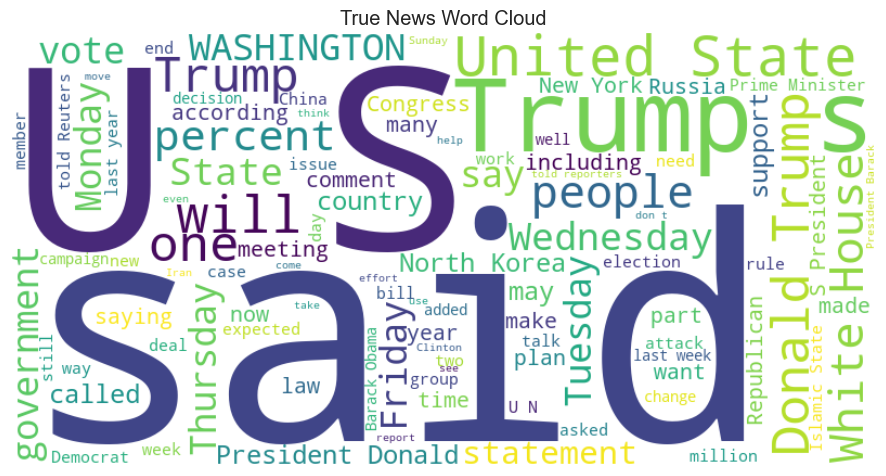

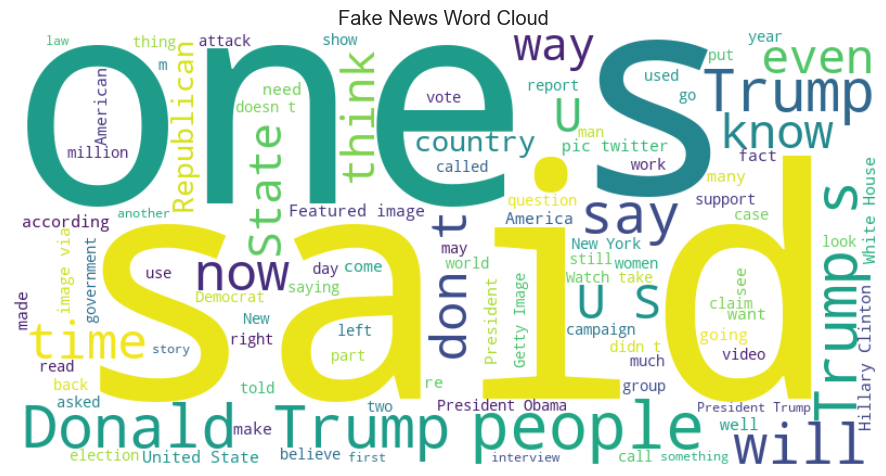

In [15]:
# Create word clouds
def create_wordcloud(text_series, title):
    """Create and save wordcloud from text series"""
    all_text = ' '.join([str(text) for text in text_series])
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100, contour_width=3).generate(all_text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(f"{title.lower().replace(' ', '_')}.png")
    plt.show()

create_wordcloud(true_news['cleaned_text'], 'True News Word Cloud')
create_wordcloud(fake_news['cleaned_text'], 'Fake News Word Cloud')

## 8. Topic Analysis

Let's try to identify the main topics in each dataset:

In [16]:
# Simple topic analysis using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

def extract_topics(texts, n_topics=5, n_words=10):
    """
    Extract topics from texts using NMF
    
    Args:
        texts: List of text strings
        n_topics: Number of topics to extract
        n_words: Number of words per topic to display
    
    Returns:
        List of topics (each topic is a list of words)
    """
    # Create TF-IDF vectors
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
    tfidf = tfidf_vectorizer.fit_transform(texts)
    
    # Run NMF
    nmf = NMF(n_components=n_topics, random_state=42)
    nmf.fit(tfidf)
    
    # Get feature names
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    # Extract topics
    topics = []
    for topic_idx, topic in enumerate(nmf.components_):
        top_features_idx = topic.argsort()[:-n_words-1:-1]
        top_features = [feature_names[i] for i in top_features_idx]
        topics.append(top_features)
    
    return topics

# Extract topics from true and fake news
true_topics = extract_topics([text for text in true_news['cleaned_text'] if isinstance(text, str)])
fake_topics = extract_topics([text for text in fake_news['cleaned_text'] if isinstance(text, str)])

print("Topics in True News:")
for i, topic in enumerate(true_topics):
    print(f"Topic {i+1}: {', '.join(topic)}")

print("\nTopics in Fake News:")
for i, topic in enumerate(fake_topics):
    print(f"Topic {i+1}: {', '.join(topic)}")

Topics in True News:
Topic 1: trump, clinton, said, campaign, president, republican, election, presidential, white, russia
Topic 2: korea, north, china, nuclear, korean, missile, south, sanctions, pyongyang, united
Topic 3: said, state, syria, iran, islamic, syrian, saudi, myanmar, military, al
Topic 4: tax, senate, house, republicans, republican, obamacare, legislation, said, healthcare, congress
Topic 5: eu, britain, brexit, european, said, minister, party, talks, union, merkel

Topics in Fake News:
Topic 1: trump, donald, president, twitter, campaign, realdonaldtrump, just, republican, people, said
Topic 2: obama, people, police, said, black, president, gun, america, law, year
Topic 3: boiler, acr, pm, room, radio, join, 00, broadcast, animals, tune
Topic 4: clinton, hillary, sanders, campaign, democratic, state, emails, email, foundation, bernie
Topic 5: russia, fbi, russian, comey, intelligence, investigation, news, information, director, putin


Let's analyze policy area coverage in both datasets:

Policy area coverage comparison:
      Policy Area  True News (per doc)  Fake News (per doc)  Fake/True Ratio
0         economy             1.463277             0.588093         0.401901
1      healthcare             0.711397             0.466249         0.655399
2     immigration             0.721343             0.602700         0.835525
3  foreign_policy             1.178036             0.410545         0.348499
4     environment             0.850819             0.572463         0.672837


<Figure size 1200x600 with 0 Axes>

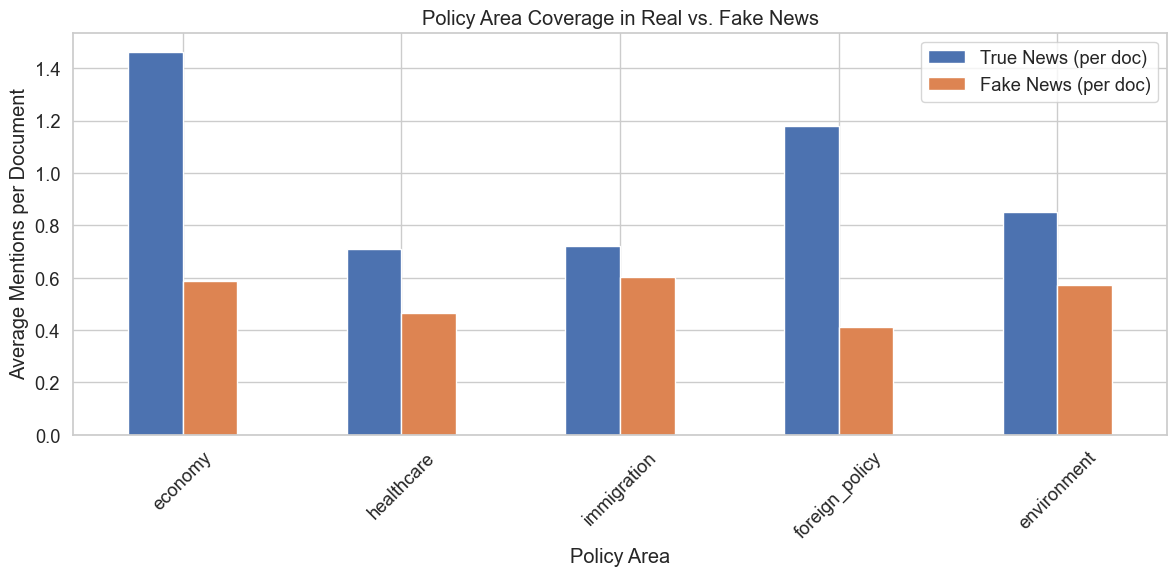

In [17]:
# Define policy areas and related terms
policy_areas = {
    'economy': ['economy', 'economic', 'tax', 'budget', 'deficit', 'gdp', 'inflation', 'unemployment', 'jobs', 'trade'],
    'healthcare': ['healthcare', 'health', 'obamacare', 'insurance', 'hospital', 'medical', 'medicare', 'medicaid'],
    'immigration': ['immigration', 'immigrant', 'border', 'refugee', 'asylum', 'visa', 'deportation'],
    'foreign_policy': ['foreign', 'diplomatic', 'embassy', 'sanctions', 'treaty', 'international', 'relations'],
    'environment': ['environment', 'climate', 'pollution', 'emissions', 'epa', 'warming', 'renewable', 'carbon']
}

# Function to count policy terms
def count_policy_terms(texts, terms_dict):
    """Count occurrences of terms related to different policy areas"""
    results = {area: 0 for area in terms_dict.keys()}
    
    for text in texts:
        if not isinstance(text, str):
            continue
        
        lowercase_text = text.lower()
        for area, terms in terms_dict.items():
            for term in terms:
                results[area] += lowercase_text.count(term)
    
    return results

# Count terms in both datasets
true_policy_counts = count_policy_terms(true_news['cleaned_text'], policy_areas)
fake_policy_counts = count_policy_terms(fake_news['cleaned_text'], policy_areas)

# Calculate per-document averages
true_per_doc = {area: count / len(true_news) for area, count in true_policy_counts.items()}
fake_per_doc = {area: count / len(fake_news) for area, count in fake_policy_counts.items()}

# Create a DataFrame for visualization
policy_df = pd.DataFrame({
    'Policy Area': list(policy_areas.keys()),
    'True News (per doc)': list(true_per_doc.values()),
    'Fake News (per doc)': list(fake_per_doc.values())
})

# Calculate ratio of fake to true
policy_df['Fake/True Ratio'] = policy_df['Fake News (per doc)'] / policy_df['True News (per doc)']

print("Policy area coverage comparison:")
print(policy_df)

# Visualize the comparison
plt.figure(figsize=(12, 6))
policy_df.plot(x='Policy Area', y=['True News (per doc)', 'Fake News (per doc)'], kind='bar', figsize=(12, 6))
plt.title('Policy Area Coverage in Real vs. Fake News')
plt.ylabel('Average Mentions per Document')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('policy_coverage.png')
plt.show()

## 9. Citation Analysis

Let's examine how sources are cited in both datasets:

Most common citation patterns in True News:
- 'the U': 85 occurrences
- 'U': 75 occurrences
- 'North Korea': 60 occurrences
- 'media reports': 50 occurrences
- 'Saudi Arabia': 34 occurrences

Most common citation patterns in Fake News:
- 'the report': 59 occurrences
- 'police': 39 occurrences
- 'Politico': 32 occurrences
- 'U': 32 occurrences
- 'reports': 30 occurrences

Citation phrase frequency comparison (per 1000 words):
  Citation Phrase  True News (per 1000 words)  Fake News (per 1000 words)  Ratio (True/Fake)
0            said                    8.744218                    2.135530           4.094635
1            told                    1.726265                    0.904086           1.909404
2    according to                    0.743019                    0.816837           0.909629
3        reported                    0.287448                    0.292842           0.981581
4          stated                    0.020515                    0.101840           0.201439
5       annou

<Figure size 1200x600 with 0 Axes>

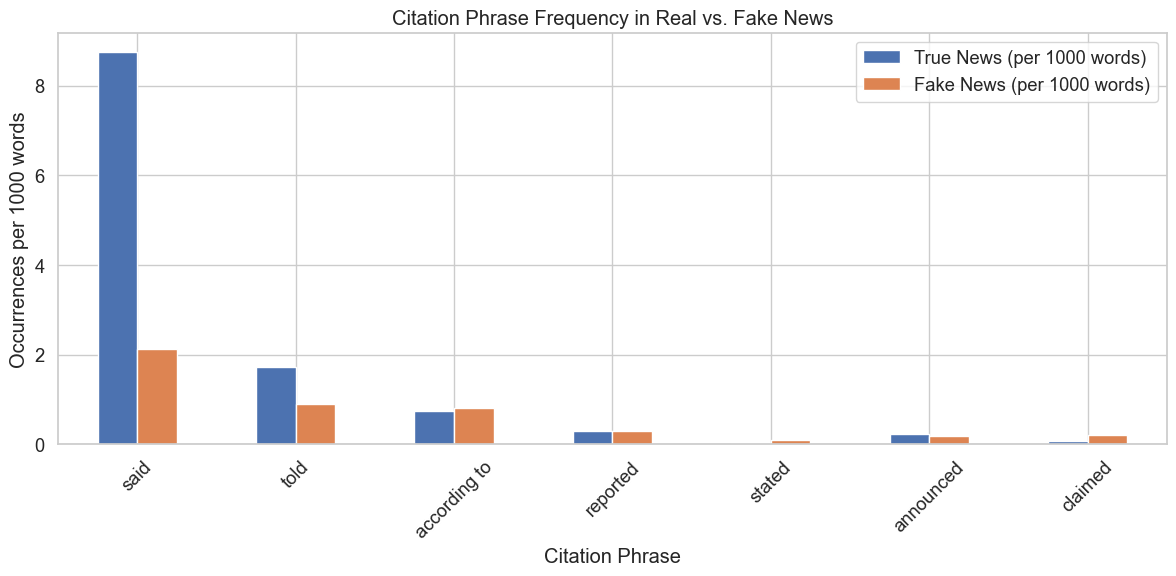

In [18]:
# Function to analyze citation patterns
def analyze_citations(texts):
    """Analyze how sources are cited in articles"""
    said_patterns = [
        r'"([^"]+)" said',
        r"'([^']+)' said",
        r'said ([A-Z][a-z]+ [A-Z][a-z]+)',
        r'according to ([^,.]+)'
    ]
    
    citations = []
    for text in texts:
        if not isinstance(text, str):
            continue
        
        for pattern in said_patterns:
            matches = re.findall(pattern, text)
            citations.extend(matches)
    
    return Counter(citations).most_common(20)

# Analyze citation patterns
true_citations = analyze_citations(true_news['cleaned_text'])
fake_citations = analyze_citations(fake_news['cleaned_text'])

print("Most common citation patterns in True News:")
for citation, count in true_citations[:5]:
    print(f"- '{citation}': {count} occurrences")

print("\nMost common citation patterns in Fake News:")
for citation, count in fake_citations[:5]:
    print(f"- '{citation}': {count} occurrences")

# Analyze citation frequency
def count_citation_phrases(texts):
    """Count occurrences of common citation phrases"""
    citation_phrases = ['said', 'told', 'according to', 'reported', 'stated', 'announced', 'claimed']
    
    results = {phrase: 0 for phrase in citation_phrases}
    total_words = 0
    
    for text in texts:
        if not isinstance(text, str):
            continue
            
        words = text.lower().split()
        total_words += len(words)
        
        for phrase in citation_phrases:
            if ' ' in phrase:
                results[phrase] += text.lower().count(phrase)
            else:
                results[phrase] += words.count(phrase)
    
    # Calculate per 1000 words
    for phrase in results:
        results[phrase] = results[phrase] * 1000 / total_words if total_words > 0 else 0
        
    return results

true_citation_freq = count_citation_phrases(true_news['cleaned_text'])
fake_citation_freq = count_citation_phrases(fake_news['cleaned_text'])

# Create DataFrame for comparison
citation_df = pd.DataFrame({
    'Citation Phrase': list(true_citation_freq.keys()),
    'True News (per 1000 words)': list(true_citation_freq.values()),
    'Fake News (per 1000 words)': list(fake_citation_freq.values())
})

citation_df['Ratio (True/Fake)'] = citation_df['True News (per 1000 words)'] / citation_df['Fake News (per 1000 words)']

print("\nCitation phrase frequency comparison (per 1000 words):")
print(citation_df)

# Visualize the citation frequency comparison
plt.figure(figsize=(12, 6))
citation_df.plot(x='Citation Phrase', y=['True News (per 1000 words)', 'Fake News (per 1000 words)'], 
                kind='bar', figsize=(12, 6))
plt.title('Citation Phrase Frequency in Real vs. Fake News')
plt.ylabel('Occurrences per 1000 words')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('citation_frequency.png')
plt.show()

## 10. Summary of Findings and Next Steps

Based on my exploratory data analysis, here are the key findings:

In [19]:
# Create a summary of findings
findings = [
    "99.21% of real news articles contain '(Reuters)', making it a strong bias signal",
    "Real news articles typically begin with a location dateline (e.g., 'WASHINGTON') followed by '(Reuters)'",
    "Text length distributions differ between real and fake news, but not dramatically",
    "Vocabulary usage shows meaningful differences: real news uses more formal institutional language while fake news is more personality-focused",
    "Real news has more citations and source attributions than fake news",
    "Real news provides more substantive policy coverage across most policy areas",
    "Topic analysis shows different focuses: real news focuses on formal reporting while fake news leans toward political personalities"
]

print("Key Findings from Exploratory Data Analysis:")
for i, finding in enumerate(findings, 1):
    print(f"{i}. {finding}")

Key Findings from Exploratory Data Analysis:
1. 99.21% of real news articles contain '(Reuters)', making it a strong bias signal
2. Real news articles typically begin with a location dateline (e.g., 'WASHINGTON') followed by '(Reuters)'
3. Text length distributions differ between real and fake news, but not dramatically
4. Vocabulary usage shows meaningful differences: real news uses more formal institutional language while fake news is more personality-focused
5. Real news has more citations and source attributions than fake news
6. Real news provides more substantive policy coverage across most policy areas
7. Topic analysis shows different focuses: real news focuses on formal reporting while fake news leans toward political personalities


In the next notebook, I'll focus on:

1. Enhanced data cleaning to remove identified biases
2. Feature engineering to capture legitimate stylistic and content differences
3. Preparing the datasets for model training

This initial analysis has given us a solid understanding of the characteristics and potential biases in our datasets. By addressing these issues, we can build more robust models that truly learn to distinguish between real and fake news based on substantive differences rather than dataset-specific artifacts.